### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
X_train.shape

(52500, 12)

In [5]:
#classes for pipline

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

def plot_view(y_test,y_score,model_type):
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + model_type)
    plt.savefig('ROC.png')
    plt.show()
 
def ConfusionMatrix_view(y_test,y_score,thresholds,model_type,business_threshold=1):
    
    font = {'size' : 15}

    plt.rc('font', **font)

    business_threshold = 1  # подберем порог для улучшения бизнесс показателя

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds*business_threshold)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix ' + model_type)
    plt.savefig("conf_matrix.png")
    plt.show()
    
def ResultOfMetrics(model_type,y_test,y_score,df_result,b=1):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    plot_view(y_test,y_score,model_type)
    ConfusionMatrix_view(y_test,y_score,thresholds[ix],model_type,business_threshold=1)

    df_result.loc[len(df_result)+1] = [model_type, roc_auc_score(y_test, y_score), precision[ix], recall[ix], fscore[ix]]

In [8]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [9]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [10]:
df_result = pd.DataFrame({'type': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f-score': [], })


In [11]:
#LogisticRegression
model_type = 'LogisticRegression'

classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

#кросс-валидация
cv_scores = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]
y_score

CV score is 0.786654902527232+-0.004877554111899307


array([0.21919629, 0.24759828, 0.40484498, ..., 0.16941878, 0.70519218,
       0.75098778])

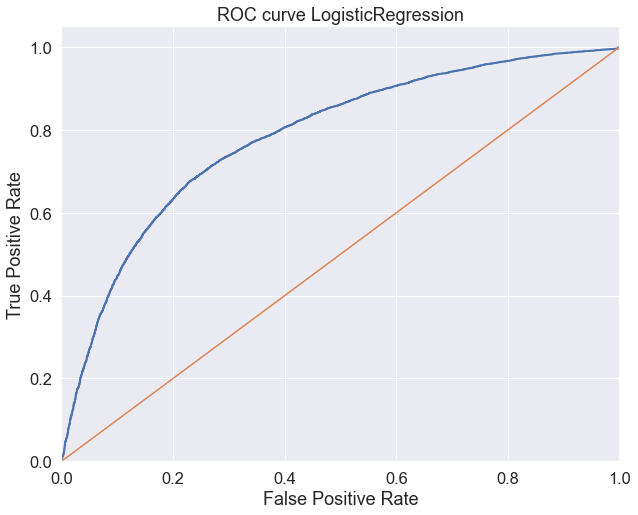

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


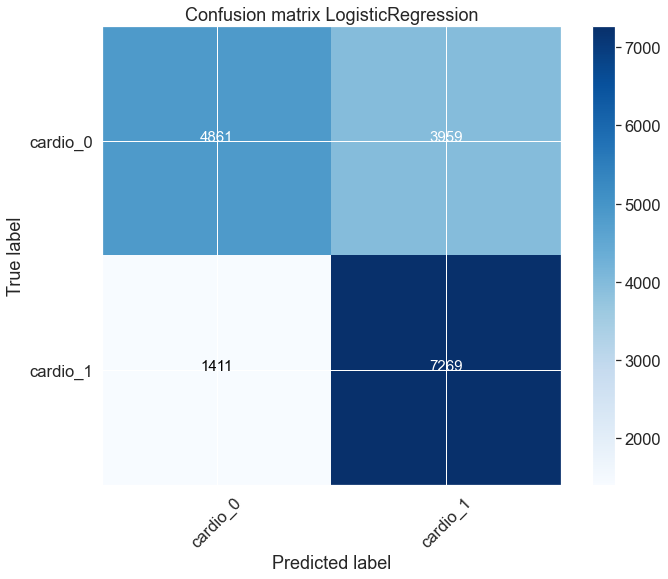

In [12]:
ResultOfMetrics(model_type,y_test,y_score,df_result,b=1)

In [13]:
%%time

#GradientBoostingRegressor
model_type = 'GradientBoostingRegressor'

classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state = 42)),
])

#кросс-валидация
cv_scores = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

CV score is 0.802139052704007+-0.004666665866248266
Wall time: 50.8 s


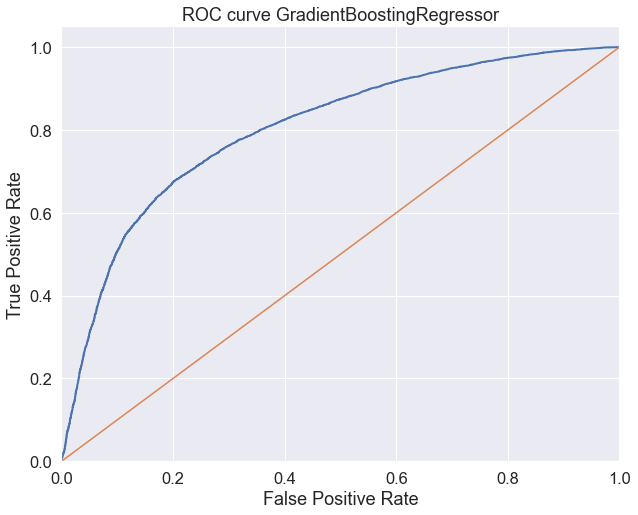

Confusion matrix, without normalization
[[5580 3240]
 [1675 7005]]


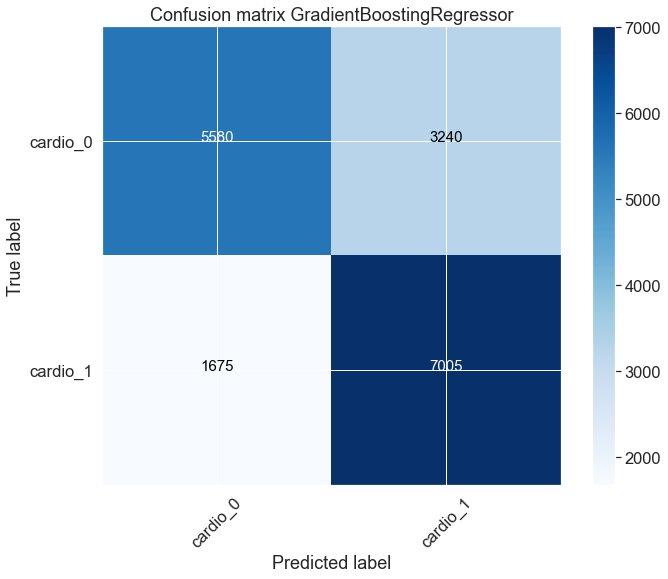

In [14]:
ResultOfMetrics(model_type,y_test,y_score,df_result,b=1)

In [15]:
%%time

#RandomForestRegressor
model_type = 'RandomForestRegressor'

classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestRegressor(random_state = 42)),
])

#кросс-валидация
cv_scores = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

CV score is 0.7702780763126426+-0.004174100243177388
Wall time: 2min 34s


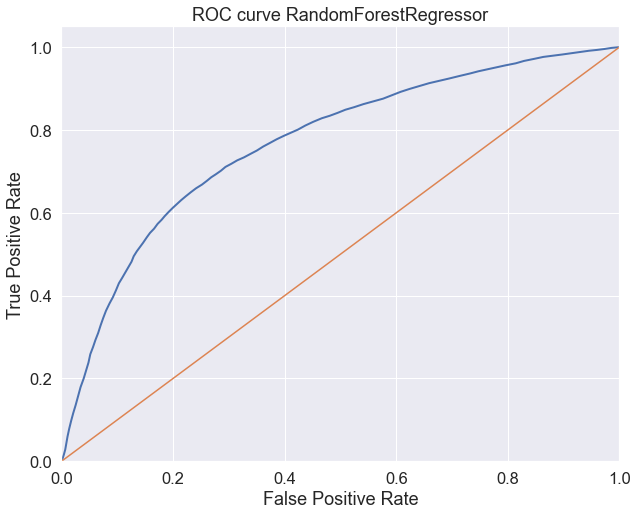

Confusion matrix, without normalization
[[4841 3979]
 [1566 7114]]


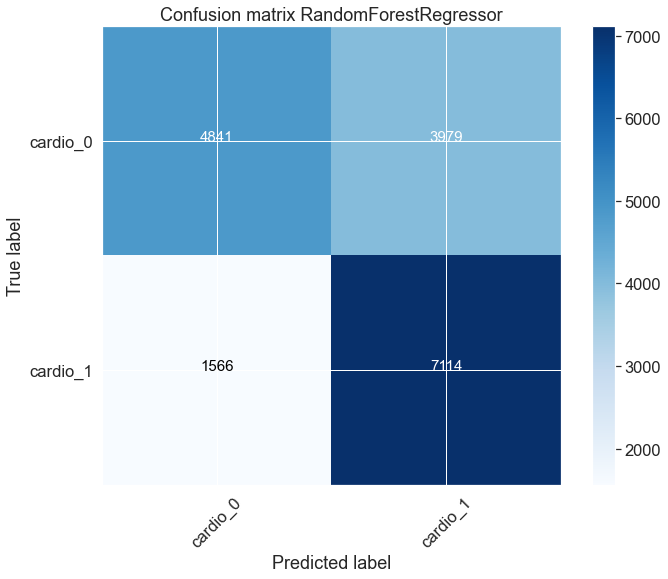

In [16]:
ResultOfMetrics(model_type,y_test,y_score,df_result,b=1)

In [17]:
df_result

,type,roc_auc,precision,recall,f-score
1,LogisticRegression,0.784035,0.647431,0.837558,0.730323
2,GradientBoostingRegressor,0.802327,0.683779,0.807143,0.740357
3,RandomForestRegressor,0.767748,0.641338,0.819700,0.719632


ВЫВОД: Из получившихся результатов видно, что выигрывает обучение на GradientBoostingRegressor. Но в процессе обучения все метрики брались со значением параметров по-умолчанию. Предполагаю, что при изменении параметров можно добиться превосходящих результатов на RandomForestRegressor.

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

ОТВЕТ: для несбалансированных классов лучшем образом подходит precision_recall_curve. Причина заключается в использовании TN значений в значении FP результатов в кривой ROC.